# Final Model Pipeline (Version 2, with updated stopwords extracted from the junk topics of the previous iteration V1)

Date of Creation: 2 Dec 2021

# Step 1: Data Preparation

This is for the final dataset containing all texts, in both English and any other foreign language. All texts have been truncated at the mean value threshold of 12558 characters.

In [1]:
## CODE ADAPTED FROM: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [2]:
import numpy as np
import pandas as pd

In [3]:
truncated = pd.read_csv("FINAL_DATASET_TRUNC.csv", index_col=0)
truncated.head()

,Text,organization,original_language,Text_translated
0,2 Degrees Investing Initiative - World Benchma...,2° investing initiative (2°ii),english,2 Degrees Investing Initiative - World Benchma...
1,2 Degrees Investing Initiative in standoff wit...,2° investing initiative (2°ii),english,2 Degrees Investing Initiative in standoff wit...
2,2° Investing Initiative GRESB About Our Work O...,2° investing initiative (2°ii),english,2° Investing Initiative GRESB About Our Work O...
3,Magic Garden Seeds - Samen & Saatgut Coupon Re...,A SEED Europe,english,Magic Garden Seeds - Samen & Saatgut Coupon Re...
4,A SEED Europe | European Youth Portal Den euro...,A SEED Europe,english,A SEED Europe | European Youth Portal Den euro...


In [4]:
# FOR EACH ORGANIZATION, MERGE THE TEXTS CORRESPONDING TO THAT ORGANIZATION

In [5]:
unique_orgs = list(truncated.organization.unique())
unique_orgs

['2° investing initiative (2°ii)',
 'A SEED Europe',
 'A Sud Ecology and Cooperation - Onlus',
 'ACT Alliance - Action by Churches Together',
 'Abibimman Foundation',
 'Academy for Mountain Environics',
 'Action Planéterre',
 'Action Solidarité Tiers-Monde a.s.b.l.',
 'ActionAid International',
 'Adaptation Fund Board',
 'Adelphi Research',
 'Advocates for the Environment, Inc.',
 'Africa Centre for Citizens Orientation',
 'Africa Youths International Development Foundation',
 'African Centre for Technology Studies',
 'African Centre of Meteorological Application for Development',
 'African Climate Change Research Centre',
 'African Development Bank Group',
 'African Forest Forum',
 'African Union Commission',
 'African Wildlife Foundation',
 'African, Caribbean and Pacific Group of States',
 'Agriconsulting S.p.A.',
 'Air and Waste Management Association',
 'All China Environment Federation',
 'All India Women’s Conference',
 'Alliance to Save Energy',
 'Amazon Environmental Research 

In [6]:
text_collection = []

for org in unique_orgs:
    merged_text = ' '.join(str(x) for x in truncated.Text_translated[truncated.organization == org])
    text_collection.append(merged_text)
    

In [7]:
print(len(unique_orgs), len(text_collection))

1118 1118


In [8]:
df = pd.DataFrame(list(zip(list(unique_orgs), text_collection)), columns=['organization', 'Text'])

In [9]:
df

,organization,Text
0,2° investing initiative (2°ii),2 Degrees Investing Initiative - World Benchma...
1,A SEED Europe,Magic Garden Seeds - Samen & Saatgut Coupon Re...
2,A Sud Ecology and Cooperation - Onlus,Who we are - Progetto Sud | Istituto per la Co...
3,ACT Alliance - Action by Churches Together,About us | ACT Alliance EU About us – ACT Alli...
4,Abibimman Foundation,Abibiman Foundation Home Who we are Board of D...
...,...,...
1113,ZOI Environment Network,Products | Zoï Environment Network Home About...
1114,Zhenjiang Green Sanshan Environmental Public W...,Department of Human Services [if IE 9] You may...
1115,atmosfair gGmbH,Emissions calculation - atmosfair Contact FAQs...
1116,iuventum e.V.,"iuventum - Wikipedia iuventum From Wikipedia, ..."


In [10]:
df2 = df.rename({'Text': 'merged_texts'}, axis=1)
df2

,organization,merged_texts
0,2° investing initiative (2°ii),2 Degrees Investing Initiative - World Benchma...
1,A SEED Europe,Magic Garden Seeds - Samen & Saatgut Coupon Re...
2,A Sud Ecology and Cooperation - Onlus,Who we are - Progetto Sud | Istituto per la Co...
3,ACT Alliance - Action by Churches Together,About us | ACT Alliance EU About us – ACT Alli...
4,Abibimman Foundation,Abibiman Foundation Home Who we are Board of D...
...,...,...
1113,ZOI Environment Network,Products | Zoï Environment Network Home About...
1114,Zhenjiang Green Sanshan Environmental Public W...,Department of Human Services [if IE 9] You may...
1115,atmosfair gGmbH,Emissions calculation - atmosfair Contact FAQs...
1116,iuventum e.V.,"iuventum - Wikipedia iuventum From Wikipedia, ..."


### Americanizing all the words (i.e. transforming all words that are originally in British English to American English)

In [11]:
import requests

def americanize(string):
    url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
    british_to_american_dict = dict(requests.get(url).json())    

    for british_spelling, american_spelling in british_to_american_dict.items():
        string = string.replace(british_spelling, american_spelling)
  
    return string

In [12]:
# Apply the americanize function to the dataframe
df['Text'] = df['Text'].apply(func = americanize)

In [13]:
import re
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

## Stopwords Removal section

In [17]:
# bring new stopwords from the junk topics of the previous iterations 
# (16 topic model, 5 junk topics, top 1% words from each of the junk topics ~ 1220 words * 5 = 6100 words)

junk = pd.read_excel("junk_words_model_16t_top_1220.xlsx", index_col=0)
initial_junk_words = list(junk.word)
print(len(initial_junk_words))
initial_junk_words_SET = list(set(initial_junk_words))
print(len(initial_junk_words_SET))



6100
1229


In [18]:
# REMOVE STOP WORDS
# NLTK Stop words
from nltk.corpus import stopwords
stop_words_eng = list(stopwords.words('english'))
stop_words_fr = list(stopwords.words('french'))
stop_words_sp = list(stopwords.words('spanish'))
stop_words_de = list(stopwords.words('german'))
stop_words = stop_words_eng + stop_words_fr + stop_words_sp + stop_words_de
stop_words.extend(["retrieved", "retrieve", "january","february","march","april", "may","june", "july", 
                   "august","september", "october", "november", "december","wikipedia", "facebook", 
                   "instagram", "linkedIn","used", "u", "U", "b", "lat", "lon", 
                   "archived", "archive", "download","about", "events", "careers", "contact"])

# add the junk words
stop_words.extend(initial_junk_words_SET)

In [19]:
# Convert to list 
data = df.Text.values.tolist()  
# Remove new line characters 
data = [re.sub(r'\s+', ' ', sent) for sent in data]  
# Remove distracting single quotes 
data = [re.sub(r"\'", "", sent) for sent in data]  
pprint(data[:1])

['2 Degrees Investing Initiative - World Benchmarking Alliance Skip to content '
 'Building a movement How it started Mission and vision Alliance About the '
 'Alliance Join the Alliance Meet our Allies How we work Seven systems '
 'transformations Theory of change Benchmarking SDG2000 Benchmarks Social '
 'Gender Benchmark Corporate Human Rights Benchmark Food and Agriculture '
 'Seafood Stewardship Index Access to Seeds Index Climate and Energy Just '
 'transition Nature Digital Inclusion Financial System Companies About us Team '
 'Careers and culture Funding partners Governance Ambassadors Finances Contact '
 'Content News and events Keeping you updated on our work Research and '
 'publications Sharing our latest data, findings and insights Impact Building '
 'a movement In the media Allies Companies This site makes use of third-party '
 'cookies for analytics. By continuing to use the site, you accept the use of '
 'cookies. Our privacy statement Accept France 2 Degrees Investing 

In [20]:
# TRANSFORM TEXT TO LIST OF INDIVIDUAL WORDS

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['degrees', 'investing', 'initiative', 'world', 'benchmarking', 'alliance', 'skip', 'to', 'content', 'building', 'movement', 'how', 'it', 'started', 'mission', 'and', 'vision', 'alliance', 'about', 'the', 'alliance', 'join', 'the', 'alliance', 'meet', 'our', 'allies', 'how', 'we', 'work', 'seven', 'systems', 'transformations', 'theory', 'of', 'change', 'benchmarking', 'sdg', 'benchmarks', 'social', 'gender', 'benchmark', 'corporate', 'human', 'rights', 'benchmark', 'food', 'and', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'to', 'seeds', 'index', 'climate', 'and', 'energy', 'just', 'transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'companies', 'about', 'us', 'team', 'careers', 'and', 'culture', 'funding', 'partners', 'governance', 'ambassadors', 'finances', 'contact', 'content', 'news', 'and', 'events', 'keeping', 'you', 'updated', 'on', 'our', 'work', 'research', 'and', 'publications', 'sharing', 'our', 'latest', 'data', 'findings', 'and', 'insigh

## Extra Step:
### Removing words with less than 2 characters

In [21]:
def remove_two_letter_words(words):
    result = []
    for word in words:
        if len(word) > 2:
            result.append(word)
    return result

for i in range(len(data_words)):
    data_words[i] = remove_two_letter_words(data_words[i])
    

In [22]:
# sanity check:
local_min = []
for i in range(len(data_words)):
    word_list = data_words[i]
    local_min.append(min([len(word) for word in word_list]))
print(min(local_min))

3


In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['degrees', 'investing', 'initiative', 'world', 'benchmarking', 'alliance', 'skip_content', 'building', 'movement', 'how', 'started', 'mission', 'and', 'vision', 'alliance', 'about', 'the', 'alliance', 'join', 'the', 'alliance', 'meet', 'our', 'allies', 'how', 'work', 'seven', 'systems', 'transformations', 'theory', 'change', 'benchmarking', 'sdg', 'benchmarks', 'social', 'gender', 'benchmark', 'corporate', 'human_rights', 'benchmark', 'food', 'and', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'seeds', 'index', 'climate', 'and', 'energy', 'just_transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'companies', 'about', 'team', 'careers', 'and', 'culture', 'funding', 'partners', 'governance', 'ambassadors', 'finances', 'contact', 'content', 'news', 'and', 'events', 'keeping', 'you', 'updated', 'our', 'work', 'research', 'and', 'publications', 'sharing', 'our', 'latest', 'data', 'findings', 'and', 'insights', 'impact', 'building', 'movement', 'the', 'media

In [ ]:
# ?gensim.models.Phrases

In [ ]:
# ?gensim.models.phrases.original_scorer

In [24]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # SpaCy documentation: https://spacy.io/usage/spacy-101

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [25]:
# CALL THE FUNCTIONS IN ORDER:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['degree', 'invest', 'initiative', 'world', 'benchmarking', 'alliance', 'skip_content', 'building', 'movement', 'start', 'mission', 'vision', 'alliance', 'alliance', 'join', 'alliance', 'meet', 'ally', 'work', 'seven', 'system', 'transformation', 'theory', 'change', 'benchmarke', 'sdg', 'benchmark', 'social', 'gender', 'benchmark', 'corporate', 'human_rights', 'benchmark', 'food', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'seed', 'index', 'climate', 'energy', 'transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'company', 'team', 'culture', 'funding', 'partner', 'governance', 'ambassador', 'finance', 'content', 'news', 'keep', 'update', 'work', 'research', 'publication', 'share', 'late', 'datum', 'finding', 'insight', 'impact', 'building', 'movement', 'medium', 'ally', 'company', 'site', 'make', 'use', 'third_party', 'cookie', 'analytic', 'continue', 'use', 'site', 'accept', 'use', 'cookie', 'privacy', 'statement', 'accept', 'france', 'degree', 'inv

In [26]:
# started 15:42 -> ended 15:45

In [27]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  # doc2bow = document to bag-of-words
# View 
print(corpus[:1])

[[(0, 2), (1, 3), (2, 3), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 6), (11, 3), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 14), (20, 3), (21, 7), (22, 7), (23, 2), (24, 2), (25, 8), (26, 2), (27, 4), (28, 4), (29, 7), (30, 2), (31, 1), (32, 3), (33, 1), (34, 2), (35, 2), (36, 4), (37, 2), (38, 2), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 4), (45, 2), (46, 2), (47, 1), (48, 4), (49, 1), (50, 1), (51, 2), (52, 8), (53, 2), (54, 2), (55, 9), (56, 2), (57, 1), (58, 2), (59, 3), (60, 1), (61, 5), (62, 14), (63, 1), (64, 2), (65, 2), (66, 9), (67, 2), (68, 2), (69, 2), (70, 2), (71, 1), (72, 3), (73, 2), (74, 1), (75, 7), (76, 1), (77, 2), (78, 1), (79, 1), (80, 4), (81, 1), (82, 2), (83, 1), (84, 1), (85, 4), (86, 2), (87, 1), (88, 5), (89, 2), (90, 1), (91, 7), (92, 1), (93, 10), (94, 5), (95, 1), (96, 2), (97, 1), (98, 5), (99, 2), (100, 2), (101, 4), (102, 1), (103, 1), (104, 5), (105, 4), (106, 2), (107, 3), (108, 1), (109, 2), (110,

In [28]:
# Gensim creates unique id for each word in the document. 
# The mapping of the corpus is as follows: every pair (a, b) in fact represents (word_id, word_frequency). 

# If you want to see what word corresponds to a given id, 
# then pass the id as a key to dictionary. 
# Example: 
id2word[4]

'adaptation'

In [29]:
# to see the word frequency distribution in a given document, run this:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accept', 2),
  ('access', 3),
  ('action', 3),
  ('active', 2),
  ('adaptation', 2),
  ('advance', 1),
  ('africa', 1),
  ('agriculture', 2),
  ('align', 2),
  ('alignment', 1),
  ('alliance', 6),
  ('ally', 3),
  ('already', 1),
  ('ambassador', 2),
  ('america', 1),
  ('american', 2),
  ('analysis', 1),
  ('analytic', 1),
  ('analytical', 1),
  ('article', 14),
  ('asia', 3),
  ('assessment', 7),
  ('asset', 7),
  ('asset_manager', 2),
  ('asset_owner', 2),
  ('aug', 8),
  ('award', 2),
  ('bank', 4),
  ('become', 4),
  ('benchmark', 7),
  ('benchmarke', 2),
  ('benchmarking', 1),
  ('berlin', 3),
  ('best_practice', 1),
  ('big', 2),
  ('biodiversity', 2),
  ('blue', 4),
  ('board', 2),
  ('bond', 2),
  ('brainwave', 2),
  ('brand', 1),
  ('browse', 1),
  ('brussels', 1),
  ('building', 2),
  ('bullsh', 4),
  ('business', 2),
  ('cal', 2),
  ('calendar', 1),
  ('canada', 4),
  ('cancel', 1),
  ('carbon', 1),
  ('carbon_price', 2),
  ('category', 8),
  ('central', 2),
  ('ceo', 2

In [30]:

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=20, 
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha='auto',
#                                           per_word_topics=True)


coherence = []
for k in range(1,51):
    print('Round: '+ str(k))
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # document corpus
                                           id2word=id2word, # dictionary
                                           num_topics=k, # number of topics
                                           random_state=0, # random seem for model reproducibility
                                           update_every=1, # updates the coefficients at every x passes of the dataset; set to 1
                                           chunksize=100, # how many texts to process at once
                                           passes=10, # number of passes through the dataset for coefficient estimation
                                           alpha='auto', # Dirichlet distribution parameter that is automatically inferred in this case
                                           per_word_topics=True) #assign each word to at least a topic; 
                                                                #if set to False, words that are not indicative are going to be omitted
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, 
                                                     corpus = corpus,
                                                     coherence='u_mass')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30
Round: 31
Round: 32
Round: 33
Round: 34
Round: 35
Round: 36
Round: 37
Round: 38
Round: 39
Round: 40
Round: 41
Round: 42
Round: 43
Round: 44
Round: 45
Round: 46
Round: 47
Round: 48
Round: 49
Round: 50


In [31]:
# ?gensim.models.coherencemodel.CoherenceModel

# started: 15:47 -> ended 

In [ ]:
?gensim.models.ldamodel.LdaModel

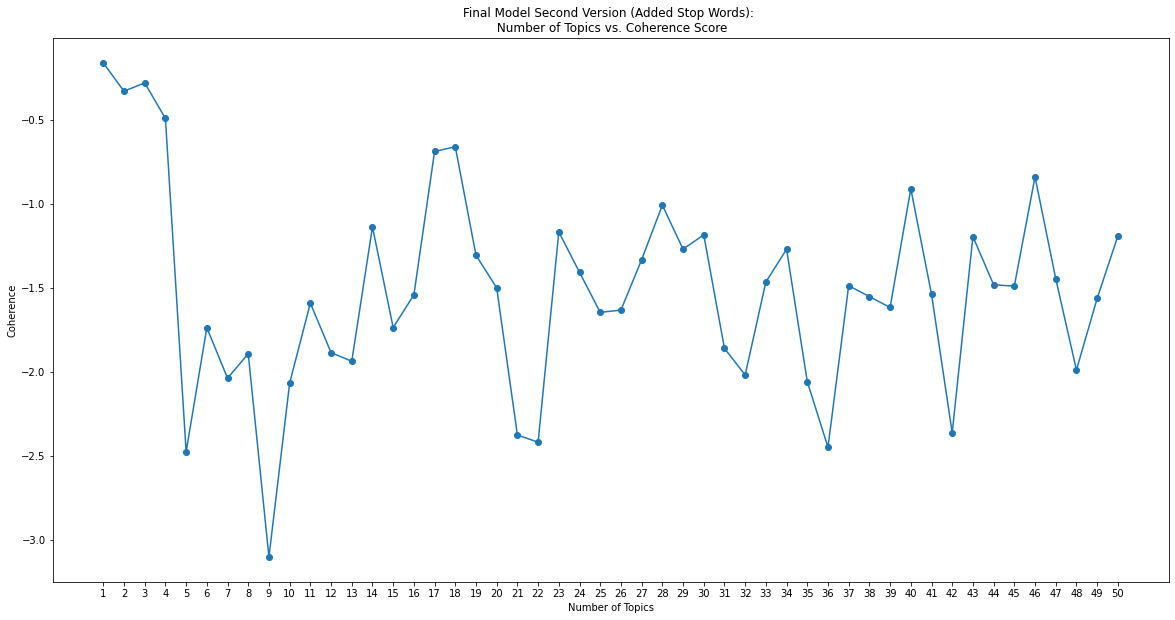

In [36]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.figure(figsize=(20,10))
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Final Model Second Version (Added Stop Words): \n Number of Topics vs. Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
#plt.show()
plt.savefig("V2 FINAL MODEL Coherence Plot.png", facecolor = "white")

In [33]:
# either 4 or 18

# Start with 4:
lda_model_4t = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_4t.show_topics(4, num_words=20, formatted=False)




[(0,
  [('climate', 0.014667264),
   ('energy', 0.013722499),
   ('project', 0.0067881537),
   ('environmental', 0.0064164926),
   ('policy', 0.006091817),
   ('change', 0.0058163),
   ('research', 0.0050617303),
   ('organization', 0.004871115),
   ('work', 0.0047480618),
   ('sustainable', 0.0043955552),
   ('global', 0.0042123855),
   ('report', 0.0041296766),
   ('world', 0.0040903953),
   ('member', 0.004036412),
   ('news', 0.0039354265),
   ('development', 0.0038886808),
   ('business', 0.00382265),
   ('environment', 0.0036490394),
   ('use', 0.0035593635),
   ('program', 0.0035215758)]),
 (1,
  [('european', 0.008273993),
   ('member', 0.007472191),
   ('france', 0.007048516),
   ('city', 0.006381187),
   ('europe', 0.005985696),
   ('french', 0.0058025103),
   ('council', 0.0056694364),
   ('marseille', 0.005378673),
   ('association', 0.0044731717),
   ('region', 0.0043977997),
   ('international', 0.004371063),
   ('water', 0.004262277),
   ('german', 0.00418421),
   ('lang

In [34]:
lda_model_4t.save("V2_4topics_model")

In [37]:
pyLDAvis.enable_notebook()
vis_4t = pyLDAvis.gensim_models.prepare(lda_model_4t, corpus, id2word, mds='mmds', sort_topics = False)
vis_4t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.085422 -0.127203       1        1  35.793957
1     -0.124450  0.215886       2        1   7.481644
2      0.049647 -0.132219       3        1  28.702128
3      0.160226  0.043536       4        1  28.022271, topic_info=               Term          Freq         Total Category  logprob  loglift
1006     university  18737.000000  18737.000000  Default  30.0000  30.0000
110          energy  15972.000000  15972.000000  Default  29.0000  29.0000
962         student  10915.000000  10915.000000  Default  28.0000  28.0000
62          climate  19300.000000  19300.000000  Default  27.0000  27.0000
1640         school   6692.000000   6692.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
319         service   2395.659519   7552.360093   Topic4  -5.9337   0.1240
434            area   2191.245002   5597.812861   Topic4  -6.0228   0.3343
179   international   2535.262004  15625.025731   Topic4  -5.8770  -0.5464
171     information   2235.698404   8287.553043   Topic4  -6.0028  -0.0380
1150      community   2131.508834   8941.659010   Topic4  -6.0505  -0.1617

[346 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
1041        1  0.029838         academic
1041        3  0.081731         academic
1041        4  0.888336         academic
10767       4  0.998618  acceptance_rate
2           1  0.537288           action
...       ...       ...              ...
1040        2  0.004756            youth
1040        3  0.959147            youth
1040        4  0.012049            youth
120543      3  0.999635             ypsa
120317      1  0.997518             ysec

[668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [38]:
pyLDAvis.save_html(vis_4t, 'V2_FINAL_4topics_pyLDAvis.html')

In [39]:
lda_model_18t = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_18t.show_topics(18, num_words=20, formatted=False)

[(0,
  [('yes', 0.026742775),
   ('island', 0.012052978),
   ('republic', 0.008005815),
   ('democratic_republic', 0.0062498157),
   ('congo', 0.0052298857),
   ('guinea_paraguay', 0.0051710852),
   ('spain_sri', 0.0048567103),
   ('israel_italy', 0.004756455),
   ('nicaragua_niger', 0.0047300598),
   ('barbuda_argentina', 0.00458237),
   ('jamaica_japan', 0.0044443524),
   ('norway_oman', 0.0044242796),
   ('lesotho_liberia', 0.0042495206),
   ('san_marino', 0.0041950657),
   ('pakistan_palau', 0.0041575236),
   ('panama_papua', 0.004095334),
   ('islands_somalia', 0.0040275557),
   ('republic_chad', 0.004022239),
   ('colombia_comoros', 0.003959421),
   ('slovenia_solomon', 0.003922462)]),
 (1,
  [('karami', 8.276224e-06),
   ('hispanoamerica', 8.276224e-06),
   ('franche', 8.276224e-06),
   ('grapheart', 8.276224e-06),
   ('jupeng', 8.276224e-06),
   ('ncarb_certificate', 8.276224e-06),
   ('larchitecture', 8.276224e-06),
   ('larsenal', 8.276224e-06),
   ('legorreta', 8.276224e-06)

In [40]:
pyLDAvis.enable_notebook()
vis_18t = pyLDAvis.gensim_models.prepare(lda_model_18t, corpus, id2word, mds='mmds', sort_topics = False)
vis_18t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.279352  0.274848       1        1   0.347691
1      0.308009  0.088231       2        1   0.000177
2      0.308009  0.088231       3        1   0.000181
3     -0.111182 -0.369349       4        1  10.132739
4      0.314390 -0.186850       5        1   0.628056
5      0.313056  0.103667       6        1   0.035552
6     -0.016284  0.285892       7        1   2.074584
7     -0.267417  0.179990       8        1   6.555470
8     -0.394740 -0.023290       9        1  12.683364
9     -0.253643 -0.147618      10        1   5.897306
10     0.041674 -0.287192      11        1   3.068987
11     0.290480 -0.016332      12        1   0.321396
12    -0.231943 -0.259109      13        1   9.540745
13    -0.278809 -0.045943      14        1  23.785497
14    -0.298766  0.067087      15        1  12.976832
15    -0.138583 -0.134581      16        1   9.440932
16     0.308009  0.088231      17        1   0.000176
17    -0.171611  0.294089      18        1   2.510313, topic_info=             Term          Freq         Total Category  logprob  loglift
1006   university  19411.000000  19411.000000  Default  30.0000  30.0000
110        energy  16450.000000  16450.000000  Default  29.0000  29.0000
62        climate  22594.000000  22594.000000  Default  28.0000  28.0000
962       student  11264.000000  11264.000000  Default  27.0000  27.0000
398       website   6096.000000   6096.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
177   institution    443.304020   3215.441597  Topic18  -5.2082   1.7033
171   information    494.250382   9185.082356  Topic18  -5.0994   0.7625
444   association    457.725220   6176.249050  Topic18  -5.1762   1.0826
294      research    469.343117  16161.509720  Topic18  -5.1511   0.1457
319       service    448.667049   8398.514450  Topic18  -5.1962   0.7552

[1288 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
3294       5  0.993327  absolutely_essential
1041       9  0.905921              academic
1041      10  0.011904              academic
1041      11  0.021301              academic
1041      13  0.005012              academic
...      ...       ...                   ...
1040      15  0.001454                 youth
1040      16  0.023559                 youth
24300      8  0.991757         zero_emission
18955     13  0.040562                zurich
18955     16  0.957888                zurich

[3591 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [41]:
pyLDAvis.save_html(vis_18t, 'V2_FINAL_18topics_pyLDAvis.html')

In [50]:
# with open('untruncated_model_3topics.txt', "w") as outfile:
#    outfile.write("\n \n".join(str(item) for item in list(lda_model_3t.show_topics(3, num_words=25, formatted=False))))

In [42]:
lda_model_18t.save("V2_18topics_model")

In [43]:
# from gensim import models

# model = models.LdaModel.load("truncated_4topics_model")
# model.show_topics()

In [44]:
def unzip_list_of_tuples(L):
    return [x[0] for x in L], [x[1] for x in L]

def transform_topic_word_list_to_df(topic_word_list):
    result = []
    for i in range(len(topic_word_list)):
        current = int(topic_word_list[i][0])
        current = current + 1
        words, scores = unzip_list_of_tuples(topic_word_list[i][1])
        topics = [current] * len(word_list)
        word_scores_topic = list(zip(words,scores,topics))
        result.extend(word_scores_topic)
    return pd.DataFrame(result, columns = ["word", "score", "topic"])

In [45]:
four_topic = list(lda_model_4t.show_topics(4, num_words=10, formatted=False))
four_topic_df = transform_topic_word_list_to_df(four_topic)
four_topic_df

,word,score,topic
0,climate,0.014667,1
1,energy,0.013722,1
2,project,0.006788,1
3,environmental,0.006416,1
4,policy,0.006092,1
5,change,0.005816,1
6,research,0.005062,1
7,organization,0.004871,1
8,work,0.004748,1
9,sustainable,0.004396,1


In [53]:
import matplotlib.pyplot as plt

def generate_side_by_side_barplots(df, n_topics):
    plt.style.use('dark_background')
    if n_topics == 4:
        plt.figure(figsize=(20,10))
        #colors = ["blue", "red", "orange", "purple"]
        for i in range(1, 5):
            t = df[df.topic==i].copy()
            plt.subplot(2,2,i)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.xlabel("Weightage")
            plt.title(f"Topic-Word Distribution, Topic {i}")
            plt.barh(list(t.word), list(t.score))
        plt.savefig("V2_4topic_model_word_barplots.png", facecolor = "black", dpi = 1000)
        plt.show()
    elif n_topics == 18:
        plt.figure(figsize=(15,15))
        for i in range(1,19):
            t = df[df.topic==i].copy()
            plt.subplot(6,3,i)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.xlabel("Weightage")
            plt.title(f"Topic-Word Distribution, Topic {i}")
            plt.barh(list(t.word), list(t.score))
        plt.savefig("V2_18topic_model_word_barplots.png", facecolor = "black", dpi = 1000)
        plt.show()
            

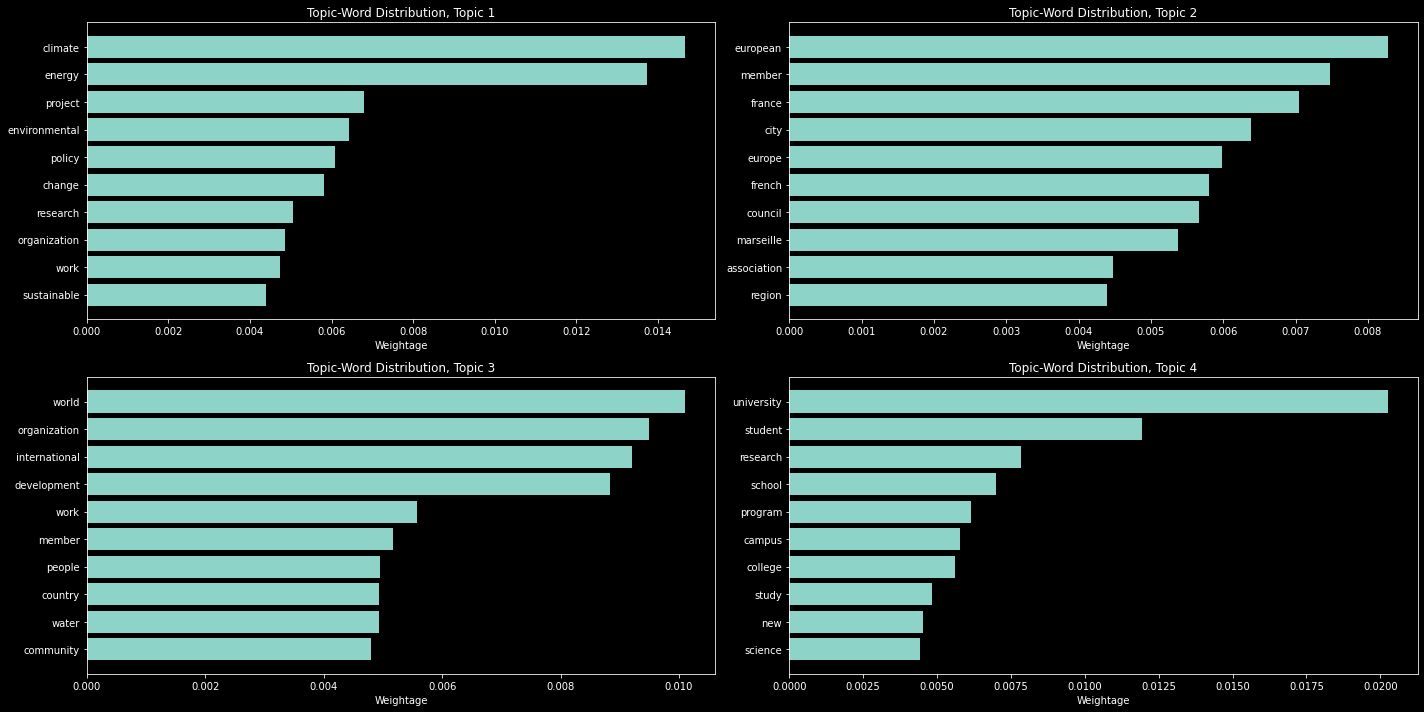

In [50]:
generate_side_by_side_barplots(four_topic_df,4)


In [51]:
eighteen_topic = list(lda_model_18t.show_topics(18, num_words=10, formatted=False))
eighteen_topic_df = transform_topic_word_list_to_df(eighteen_topic)
eighteen_topic_df

,word,score,topic
0,yes,0.026743,1
1,island,0.012053,1
2,republic,0.008006,1
3,democratic_republic,0.006250,1
4,congo,0.005230,1
...,...,...,...
175,finance,0.014384,18
176,economic,0.013957,18
177,financial,0.013918,18
178,japan,0.012574,18


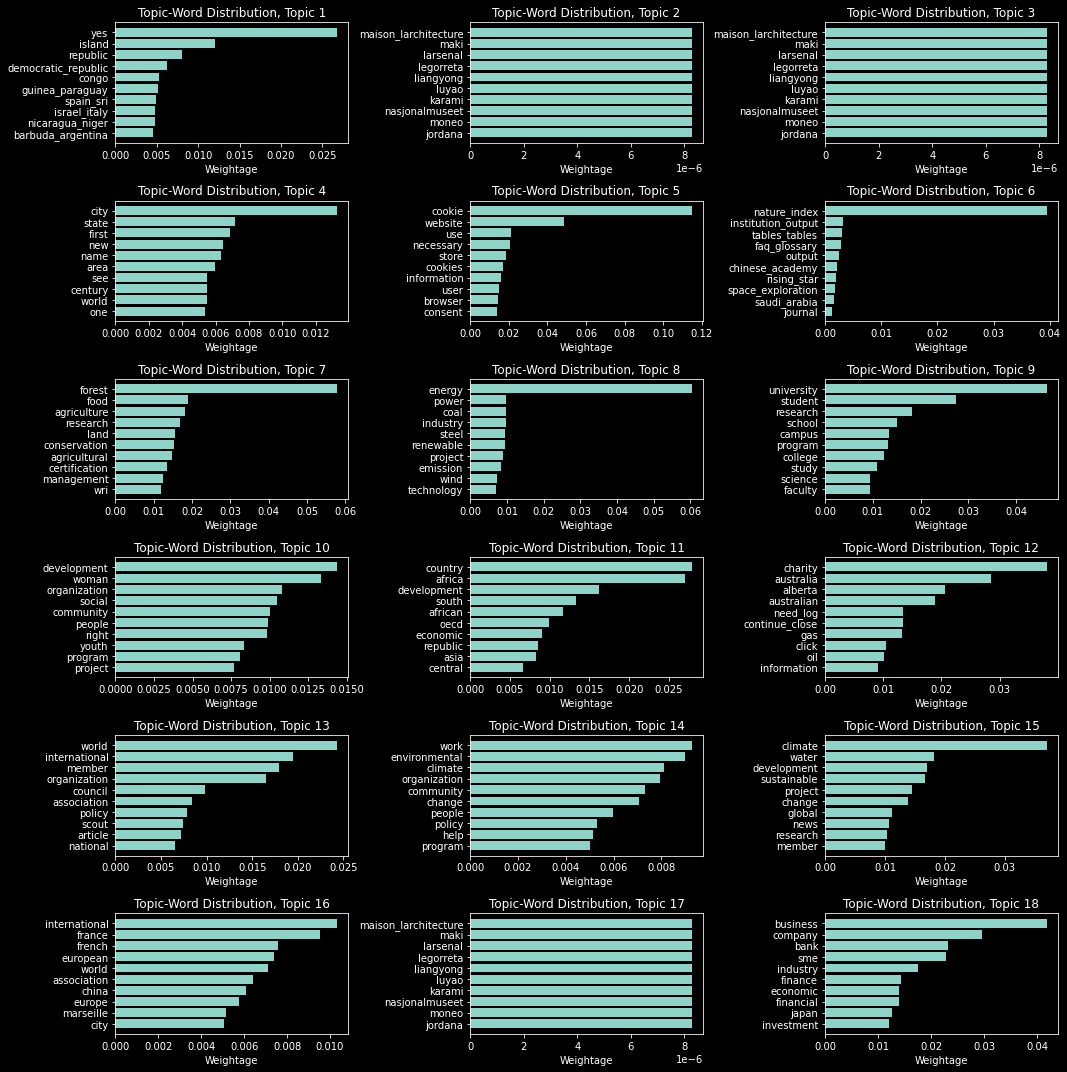

In [54]:
generate_side_by_side_barplots(eighteen_topic_df,18)

In [111]:
# We will now work with df2, a dataframe that contains the organization names + all texts for a specific organization, merged

In [117]:
document_topics_4 = list(lda_model_4t.get_document_topics(corpus, minimum_probability=0))

In [124]:
def transform_document_topic_list(list_doc_topics, index_column):
    result = []
    most_prevalent_topic = []
    for i in range(len(list_doc_topics)):
        probabilities = []
        maximum = -1
        index = -1
        topic_distrib = list_doc_topics[i]
        L = len(topic_distrib)
        for i in range(len(topic_distrib)):
            t = topic_distrib[i]
            probabilities.append(t[1])
            if t[1] > maximum:
                maximum = t[1]
                index = i + 1
        probabilities = tuple(probabilities)
        result.append(probabilities)
        most_prevalent_topic.append(index)
        
    df = pd.DataFrame(result, columns = [f"Topic{i}" for i in range(1, L+1)])
    df['most_prevalent_topic'] = most_prevalent_topic
    df['organization'] = index_column
    return df

In [126]:
E1 = transform_document_topic_list(document_topics_4, list(df2.organization))
E1

cols = E1.columns.tolist()
cols = cols[-1:] + cols[:-1]
E1 = E1[cols]
E1

,organization,Topic1,Topic2,Topic3,Topic4,most_prevalent_topic
0,2° investing initiative (2°ii),0.000120,0.960847,0.038928,0.000104,2
1,A SEED Europe,0.162033,0.757418,0.051603,0.028945,2
2,A Sud Ecology and Cooperation - Onlus,0.000055,0.841379,0.091450,0.067116,2
3,ACT Alliance - Action by Churches Together,0.177871,0.770770,0.000076,0.051283,2
4,Abibimman Foundation,0.021111,0.945866,0.032966,0.000058,2
...,...,...,...,...,...,...
1113,ZOI Environment Network,0.000116,0.992206,0.007577,0.000101,2
1114,Zhenjiang Green Sanshan Environmental Public W...,0.528333,0.449156,0.022449,0.000062,1
1115,atmosfair gGmbH,0.000038,0.222960,0.776968,0.000033,3
1116,iuventum e.V.,0.000042,0.629018,0.000075,0.370865,2


In [133]:
R1= pd.merge(E1, df2, on = "organization", how = 'left')
R1

,organization,Topic1,Topic2,Topic3,Topic4,most_prevalent_topic,merged_texts
0,2° investing initiative (2°ii),0.000120,0.960847,0.038928,0.000104,2,2 Degrees Investing Initiative - World Benchma...
1,A SEED Europe,0.162033,0.757418,0.051603,0.028945,2,Magic Garden Seeds - Samen & Saatgut Coupon Re...
2,A Sud Ecology and Cooperation - Onlus,0.000055,0.841379,0.091450,0.067116,2,Who we are - Progetto Sud | Istituto per la Co...
3,ACT Alliance - Action by Churches Together,0.177871,0.770770,0.000076,0.051283,2,About us | ACT Alliance EU About us – ACT Alli...
4,Abibimman Foundation,0.021111,0.945866,0.032966,0.000058,2,Abibiman Foundation Home Who we are Board of D...
...,...,...,...,...,...,...,...
1113,ZOI Environment Network,0.000116,0.992206,0.007577,0.000101,2,Products | Zoï Environment Network Home About...
1114,Zhenjiang Green Sanshan Environmental Public W...,0.528333,0.449156,0.022449,0.000062,1,Department of Human Services [if IE 9] You may...
1115,atmosfair gGmbH,0.000038,0.222960,0.776968,0.000033,3,Emissions calculation - atmosfair Contact FAQs...
1116,iuventum e.V.,0.000042,0.629018,0.000075,0.370865,2,"iuventum - Wikipedia iuventum From Wikipedia, ..."


In [135]:
R1 = R1[["organization", "merged_texts", "Topic1", "Topic2", "Topic3", "Topic4", "most_prevalent_topic"]]
R1

,organization,merged_texts,Topic1,Topic2,Topic3,Topic4,most_prevalent_topic
0,2° investing initiative (2°ii),2 Degrees Investing Initiative - World Benchma...,0.000120,0.960847,0.038928,0.000104,2
1,A SEED Europe,Magic Garden Seeds - Samen & Saatgut Coupon Re...,0.162033,0.757418,0.051603,0.028945,2
2,A Sud Ecology and Cooperation - Onlus,Who we are - Progetto Sud | Istituto per la Co...,0.000055,0.841379,0.091450,0.067116,2
3,ACT Alliance - Action by Churches Together,About us | ACT Alliance EU About us – ACT Alli...,0.177871,0.770770,0.000076,0.051283,2
4,Abibimman Foundation,Abibiman Foundation Home Who we are Board of D...,0.021111,0.945866,0.032966,0.000058,2
...,...,...,...,...,...,...,...
1113,ZOI Environment Network,Products | Zoï Environment Network Home About...,0.000116,0.992206,0.007577,0.000101,2
1114,Zhenjiang Green Sanshan Environmental Public W...,Department of Human Services [if IE 9] You may...,0.528333,0.449156,0.022449,0.000062,1
1115,atmosfair gGmbH,Emissions calculation - atmosfair Contact FAQs...,0.000038,0.222960,0.776968,0.000033,3
1116,iuventum e.V.,"iuventum - Wikipedia iuventum From Wikipedia, ...",0.000042,0.629018,0.000075,0.370865,2


In [136]:
R1.to_csv("FINAL_4_topics_document_topic_list.csv")

In [57]:
# document_topics_16 = list(lda_model_16t.get_document_topics(corpus, minimum_probability=0))

In [58]:
# document_topics_16

In [59]:
# E2 = transform_document_topic_list(document_topics_16, list(df2.organization))
# E2

# cols = E2.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# E2 = E2[cols]
# E2

In [60]:
# R2= pd.merge(E2, df2, on = "organization", how = 'left')
# R2

In [61]:
# cols = [f"Topic{i}" for i in range(1,17)]
# columns = ["organization", "merged_texts"] + cols + ["most_prevalent_topic"]

# R2 = R2[columns]
# R2

In [142]:
# R2.to_csv("FINAL_16_topics_document_topic_list.csv")

In [145]:
# NGOs = pd.read_csv("NGOs_COP2019_complete.csv")
# NGOs = NGOs[["name", "entity_type", "coordinator", "city", "country"]]

In [146]:
# IGOs = pd.read_csv("IGOs_COP2019_complete.csv")
# IGOs = IGOs[["name", "entity_type", "coordinator", "city", "country"]]

In [62]:
# merge_all = pd.concat([NGOs, IGOs], ignore_index=True)
#merge_all

In [63]:
# merge_all = merge_all.rename({'name': 'organization'}, axis = 1)
# merge_all

In [149]:
D1 = pd.merge(merge_all, R1, on = "organization", how = "left")
D1

,organization,entity_type,coordinator,city,country,merged_texts,Topic1,Topic2,Topic3,Topic4,most_prevalent_topic
0,Technical Centre for Agricultural and Rural Co...,Non-governmental organizations,Mr. Michael Hailu,Wageningen,Netherlands,Technical Centre for Agricultural and Rural Co...,0.000029,0.901700,0.002972,0.095298,2.0
1,The European Organisation for the Exploitation...,Non-governmental organizations,NaN,Darmstadt,Germany,European Organisation for the Exploitation of ...,0.000031,0.261649,0.718123,0.020198,3.0
2,2° investing initiative (2°ii),Non-governmental organizations,Mr. Thibaut Ghirardi,Paris,France,2 Degrees Investing Initiative - World Benchma...,0.000120,0.960847,0.038928,0.000104,2.0
3,A SEED Europe,Non-governmental organizations,Mr. Flip Vonk,Amsterdam,Netherlands,Magic Garden Seeds - Samen & Saatgut Coupon Re...,0.162033,0.757418,0.051603,0.028945,2.0
4,A Sud Ecology and Cooperation - Onlus,Non-governmental organizations,Ms. Lucie Greyl,Rome,Italy,Who we are - Progetto Sud | Istituto per la Co...,0.000055,0.841379,0.091450,0.067116,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1113,Regional Community Forestry Training Center fo...,Intergovernmental organizations,Ms. Jennifer Jadin,Bangkok,Thailand,RECOFTC – The Center for People and Forests - ...,0.000038,0.992073,0.007855,0.000033,2.0
1114,Secretaria General Iberoamericana,Intergovernmental organizations,Ms. Maria Salvadora Ortiz,Madrid,Spain,Secretary General - SEGIB Who we are SEGIB Sub...,0.002986,0.845417,0.003614,0.147984,2.0
1115,Secrétariat général de l’union du Maghreb Arabe,Intergovernmental organizations,Mme Faouzia Chakiri,Rabat,Morocco,Arab Maghreb Union - Wikipedia Arab Maghreb Un...,0.013427,0.063445,0.000030,0.923098,4.0
1116,Secretariat of the Pacific Community,Intergovernmental organizations,Ms. Sylvie Michelle Goyet,Noumea,France,Pacific Community - Wikipedia Pacific Communit...,0.000061,0.556122,0.000107,0.443710,2.0


In [152]:
# D1.to_csv("COMPLETE_DATA_COUNTRY_4TOPICS.csv")

In [64]:
# D2 = pd.merge(merge_all, R2, on = "organization", how = "left")
# D2

In [65]:
# D2.to_csv("COMPLETE_DATA_COUNTRY_16TOPICS.csv")

In [154]:
vis_4t.topic_info

,Term,Freq,Total,Category,logprob,loglift
1007,university,19509.000000,19509.000000,Default,30.0000,30.0000
294,research,14872.000000,14872.000000,Default,29.0000,29.0000
110,energy,15009.000000,15009.000000,Default,28.0000,28.0000
962,student,11360.000000,11360.000000,Default,27.0000,27.0000
1968,college,5143.000000,5143.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
226,name,1015.694184,4218.501545,Topic4,-5.9076,0.7335
316,see,1103.600413,6136.609936,Topic4,-5.8246,0.4418
1587,president,933.307674,3507.255474,Topic4,-5.9922,0.8336
956,state,1057.537401,6236.509682,Topic4,-5.8673,0.3830


In [156]:
vis_4t.token_table

,Topic,Freq,Term
term,,,
1042,1,0.342251,academic
1042,2,0.068074,academic
1042,3,0.584431,academic
1042,4,0.005333,academic
10769,1,0.004597,acceptance_rate
...,...,...,...
13673,3,0.797622,york
13673,4,0.000846,york
121658,2,0.999626,ypsa


In [160]:
# taken from: https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

all_topics = {}
lambd = 0.6  # Adjust this accordingly
for i in range(1,5): #Adjust number of topics in final model
    topic = vis_4t.topic_info[vis_4t.topic_info.Category == 'Topic'+ str(i)]
    topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd
    topic = topic.sort_values(by='relevance', ascending=False).head(10)
    print(topic)
    #all_topics['Topic '+ str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values

             Term         Freq         Total Category  logprob  loglift  \
1968      college  4588.906462   5143.774814   Topic1  -4.6798   1.7630   
11905        yale  3242.600554   3413.174079   Topic1  -5.0271   1.8259   
1007   university  6106.157142  19509.031819   Topic1  -4.3942   0.7156   
1641       school  3677.019488   6874.074001   Topic1  -4.9014   1.2515   
962       student  4030.558185  11360.968090   Topic1  -4.8096   0.8409   
4879       campus  2880.089619   5436.651462   Topic1  -5.1457   1.2418   
788           new  2868.637564   9618.661174   Topic1  -5.1496   0.6673   
1952       church  1324.843177   1443.377542   Topic1  -5.9222   1.7915   
1301        first  2097.524725   5152.628876   Topic1  -5.4627   0.9784   
956         state  2079.844578   6236.509682   Topic1  -5.4712   0.7790   

       relevance  
1968    -2.10268  
11905   -2.28590  
1007    -2.35028  
1641    -2.44024  
962     -2.54940  
4879    -2.59070  
788     -2.82284  
1952    -2.83672  
130

/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/1899062668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd
/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/1899062668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd
/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/1899062668.py:7: SettingWithCopyWarning

In [177]:
def get_pyLDAvis_topic_word_relevance_df(vis, num_topics, top_words, lambd):
    all_topics = {}
    # get the first topic information
    df = vis.topic_info[vis.topic_info.Category == 'Topic1']
    df['relevance'] = df['loglift']* (1 - lambd) + df['logprob']*lambd
    df = df.sort_values(by='relevance', ascending=False).head(top_words)
    for i in range(2, num_topics + 1):
        topic = vis.topic_info[vis.topic_info.Category == 'Topic' + str(i)]
        topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd
        topic = topic.sort_values(by='relevance', ascending=False).head(top_words)
        df = pd.concat([df, topic], ignore_index=True)
        
    # bring back the word, score, topic structure
    df['word'] = df['Term']
    df['score'] = df['relevance']
    df['topic'] = [int(x[5:]) for x in df.Category]
    return df[['word', 'score', 'topic']]

In [178]:
pyLDAvis_4t_df = get_pyLDAvis_topic_word_relevance_df(vis_4t,4,10,0.6)

/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/65997364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relevance'] = df['loglift']* (1 - lambd) + df['logprob']*lambd
/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/65997364.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd


In [179]:
pyLDAvis_4t_df

,word,score,topic
0,college,-2.10268,1
1,yale,-2.28590,1
2,university,-2.35028,1
3,school,-2.44024,1
4,student,-2.54940,1
5,campus,-2.59070,1
6,new,-2.82284,1
7,church,-2.83672,1
8,first,-2.88626,1
9,state,-2.97112,1


In [184]:
import matplotlib.pyplot as plt

def generate_side_by_side_barplots2(df, n_topics, dpi_num, subplot_xlabel, filename):
    plt.figure(figsize=(20,10))
    plt.style.use('dark_background')
    if n_topics == 4:
        #colors = ["blue", "red", "orange", "purple"]
        for i in range(1, 5):
            t = df[df.topic==i].copy()
            plt.subplot(2,2,i)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.gca().invert_xaxis()
            plt.xlabel(subplot_xlabel)
            plt.title(f"Topic {i}")
            plt.barh(list(t.word), list(t.score))
        plt.savefig(f"{filename}.png", facecolor = "black", dpi = dpi_num)
        plt.show()
    elif n_topics == 16:
        for i in range(1,17):
            t = df[df.topic==i].copy()
            plt.subplot(4,4,i)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.gca().invert_xaxis()
            plt.xlabel(subplot_xlabel)
            plt.title(f"Topic {i}")
            plt.barh(list(t.word), list(t.score))
        plt.savefig(f"{filename}.png", facecolor = "black", dpi = dpi_num)
        plt.show()

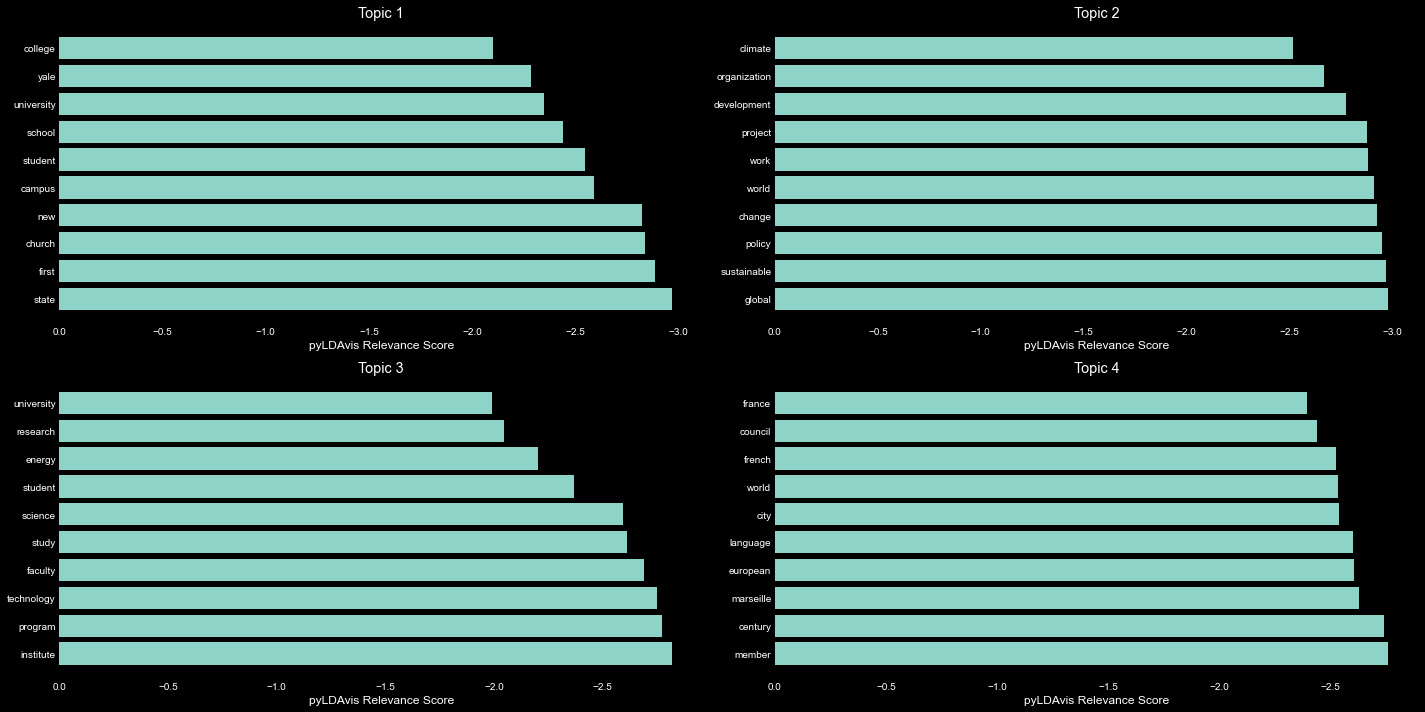

In [185]:
generate_side_by_side_barplots2(pyLDAvis_4t_df, 4, 800, "pyLDAvis Relevance Score", "FINAL_4topic_model_word_PYLDAVIS_barplots")

In [186]:
pyLDAvis_16t_df = get_pyLDAvis_topic_word_relevance_df(vis_16t,16,10,0.6)

/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/65997364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relevance'] = df['loglift']* (1 - lambd) + df['logprob']*lambd
/var/folders/6_/r43fszfx0sq37gltljwc7qqr0000gn/T/ipykernel_19508/65997364.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']* (1 - lambd) + topic['logprob']*lambd


In [187]:
pyLDAvis_16t_df

,word,score,topic
0,alvorada,-5.54542,1
1,electrolysi,-5.54542,1
2,amarante,-5.54542,1
3,afore,-5.54542,1
4,specialised,-5.54542,1
...,...,...,...
155,sofc,-5.54542,16
156,remitenergy,-5.54542,16
157,phosphoric,-5.54542,16
158,pafc,-5.54542,16


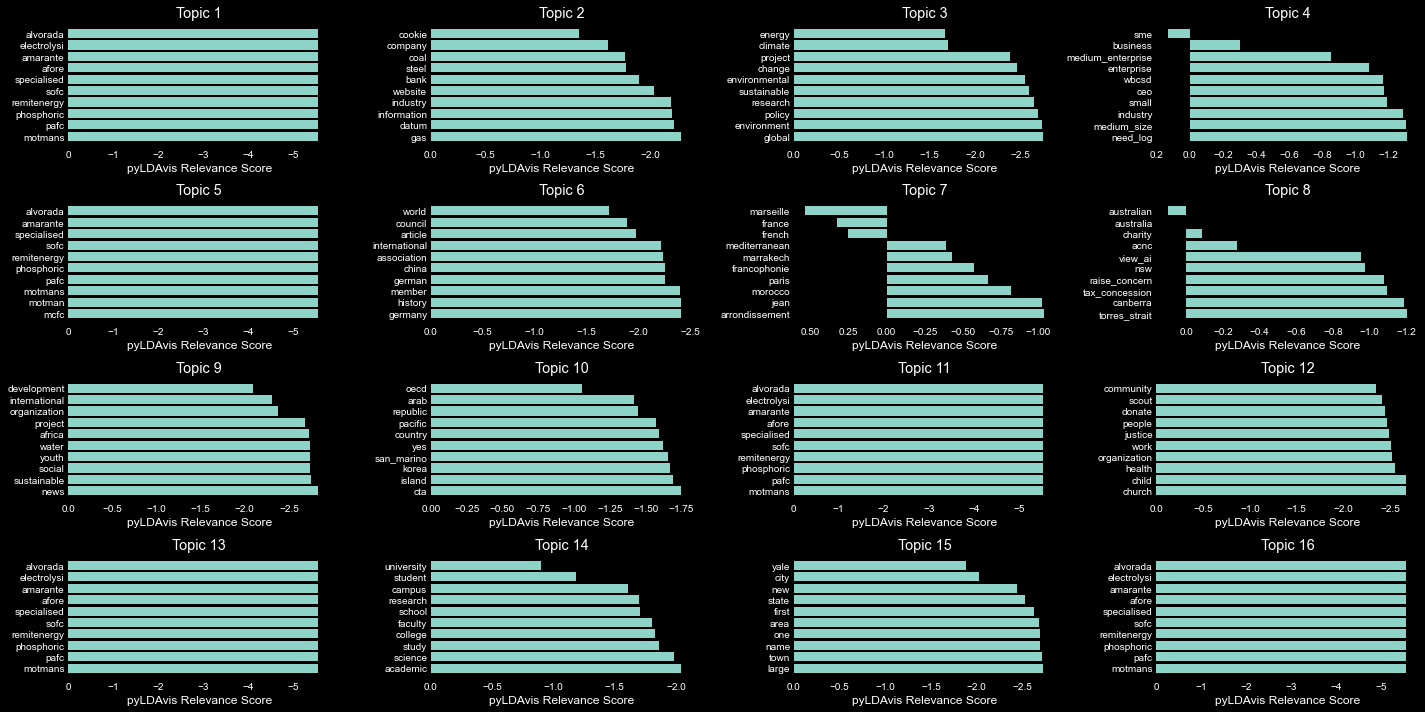

In [188]:
generate_side_by_side_barplots2(pyLDAvis_16t_df, 16, 800, "pyLDAvis Relevance Score", "FINAL_16topic_model_word_PYLDAVIS_barplots")

# T-SNE Clustering (similar to PCA)

In [79]:
# taken from:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def TSNE_plot(lda_model, corpus, n_topics):
    plt.style.use('default')
    # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list[0]])
        
    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    # arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

    X = tsne_lda[:,0]
    Y = tsne_lda[:,1]
    org_names = list(df2.organization)
    plt.figure(figsize=(20,10))
    plt.style.use('default')

    plt.scatter(x=X, y=Y, color=mycolors[topic_num])

    #for i, txt in enumerate(org_names):
    #    plt.annotate(txt, (X[i] + 0.05, Y[i] + 0.05), size = 4)
    
    # blue - topic 1
    # orange - topic 2
    # green - topic 3
    # red - topic 4
    blue_patch = mpatches.Patch(color='#1f77b4', label='Topic 1 Dominant')
    orange_patch = mpatches.Patch(color='#ff7f0e', label='Topic 2 Dominant')
    green_patch = mpatches.Patch(color='#2ca02c', label='Topic 3 Dominant')
    red_patch = mpatches.Patch(color='#d62728', label='Topic 4 Dominant')
    plt.legend(handles=[blue_patch, orange_patch, green_patch, red_patch])
    plt.title("Second Version Final Model: \n T-SNE Plot (4 topic model)")
    plt.xlabel("T-SNE PC1")
    plt.ylabel("T-SNE PC2")
    
    plt.savefig("aaaa", facecolor = "white", dpi = 500)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1118 samples in 0.001s...
[t-SNE] Computed neighbors for 1118 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1118
[t-SNE] Computed conditional probabilities for sample 1118 / 1118
[t-SNE] Mean sigma: 0.021952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.674858
[t-SNE] KL divergence after 1000 iterations: 0.423650


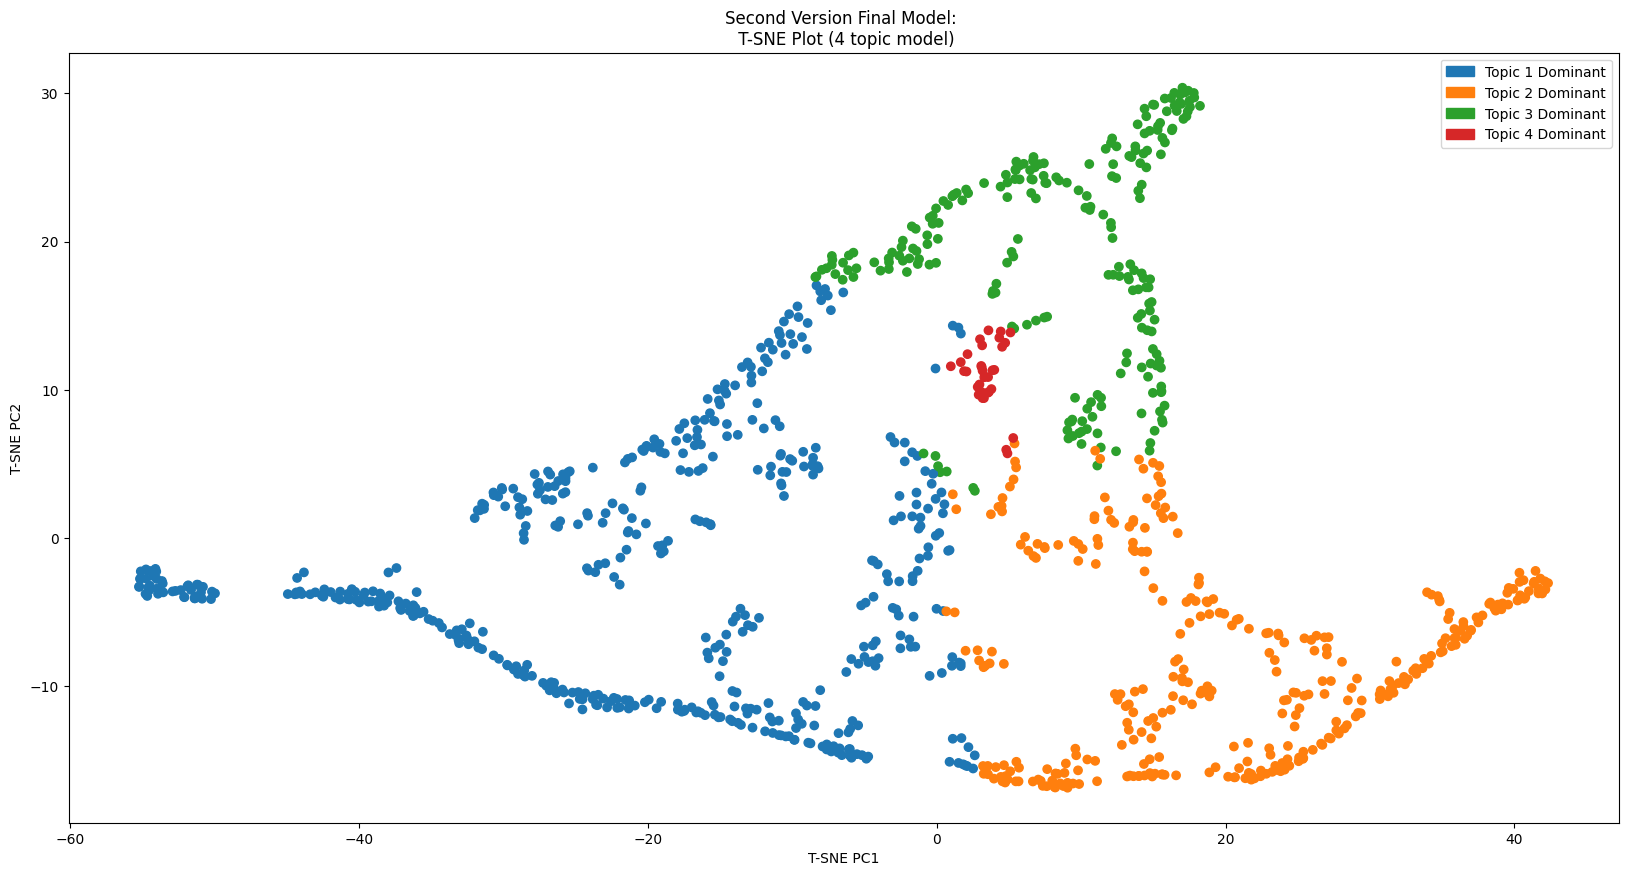

In [80]:
TSNE_plot(lda_model_4t, corpus, 4)

In [232]:
mcolors.TABLEAU_COLORS.items()

odict_items([('tab:blue', '#1f77b4'), ('tab:orange', '#ff7f0e'), ('tab:green', '#2ca02c'), ('tab:red', '#d62728'), ('tab:purple', '#9467bd'), ('tab:brown', '#8c564b'), ('tab:pink', '#e377c2'), ('tab:gray', '#7f7f7f'), ('tab:olive', '#bcbd22'), ('tab:cyan', '#17becf')])

In [237]:
df2

,organization,merged_texts
0,2° investing initiative (2°ii),2 Degrees Investing Initiative - World Benchma...
1,A SEED Europe,Magic Garden Seeds - Samen & Saatgut Coupon Re...
2,A Sud Ecology and Cooperation - Onlus,Who we are - Progetto Sud | Istituto per la Co...
3,ACT Alliance - Action by Churches Together,About us | ACT Alliance EU About us – ACT Alli...
4,Abibimman Foundation,Abibiman Foundation Home Who we are Board of D...
...,...,...
1113,ZOI Environment Network,Products | Zoï Environment Network Home About...
1114,Zhenjiang Green Sanshan Environmental Public W...,Department of Human Services [if IE 9] You may...
1115,atmosfair gGmbH,Emissions calculation - atmosfair Contact FAQs...
1116,iuventum e.V.,"iuventum - Wikipedia iuventum From Wikipedia, ..."


In [5]:
from gensim import models

model = models.LdaModel.load("/users/stefan/Desktop/IAD_blockchain/Web-scraped data/FINAL Saved Models/16 topics/final_data_16topics_model")
model.show_topics(num_topics=16, formatted=False)

[(0,
  [('khaleq', 8.200553e-06),
   ('kiara', 8.200553e-06),
   ('internal_displacement', 8.200553e-06),
   ('intlawyer', 8.200553e-06),
   ('jmm', 8.200553e-06),
   ('kavala', 8.200553e-06),
   ('icc_icl', 8.200553e-06),
   ('lawbankruptcy', 8.200553e-06),
   ('lawart', 8.200553e-06),
   ('howardkennedy', 8.200553e-06)]),
 (1,
  [('cookie', 0.01655767),
   ('company', 0.0153702125),
   ('information', 0.010584377),
   ('website', 0.010481388),
   ('bank', 0.009214179),
   ('coal', 0.008875112),
   ('steel', 0.008608666),
   ('use', 0.008543398),
   ('datum', 0.008211265),
   ('industry', 0.008017668)]),
 (2,
  [('climate', 0.025124727),
   ('energy', 0.023964869),
   ('project', 0.010717858),
   ('change', 0.0091374125),
   ('research', 0.008545405),
   ('environmental', 0.007856546),
   ('policy', 0.00762433),
   ('sustainable', 0.007500877),
   ('global', 0.006681542),
   ('development', 0.006195052)]),
 (3,
  [('business', 0.065716006),
   ('sme', 0.05852016),
   ('industry', 0.01

In [22]:
# model.get_topic_terms(0, topn = 10)

In [68]:
model.get_topics().shape

(16, 121943)

In [69]:
# shape (num_topics, vocabulary_size)
# therefore the vocabulary size is 121943 unique words
# 1% of that tis 1219.43, which approximates to 1220
# keep top 1220 of the words in each junk topic and detect overlap later
# this note was written 2 Dec 2021

In [70]:
a = model.show_topics(num_topics=16, num_words= 1220, formatted=False)

In [71]:
a[0][1]

[('rolling_stock', 8.200553e-06),
 ('lero', 8.200553e-06),
 ('leth', 8.200553e-06),
 ('macha', 8.200553e-06),
 ('madsen', 8.200553e-06),
 ('mamo', 8.200553e-06),
 ('mariman', 8.200553e-06),
 ('methodologieswe', 8.200553e-06),
 ('migrante', 8.200553e-06),
 ('modera', 8.200553e-06),
 ('mtm', 8.200553e-06),
 ('nacione', 8.200553e-06),
 ('operandi', 8.200553e-06),
 ('operationalized', 8.200553e-06),
 ('opposed', 8.200553e-06),
 ('organiza', 8.200553e-06),
 ('leonor', 8.200553e-06),
 ('parellada', 8.200553e-06),
 ('landesa', 8.200553e-06),
 ('kathe', 8.200553e-06),
 ('ethnocentric', 8.200553e-06),
 ('explica', 8.200553e-06),
 ('extractivismo', 8.200553e-06),
 ('facilitywe', 8.200553e-06),
 ('formar', 8.200553e-06),
 ('guatemaltecas', 8.200553e-06),
 ('incluyan', 8.200553e-06),
 ('inititives', 8.200553e-06),
 ('iwgiaiwgia_member', 8.200553e-06),
 ('iwgias', 8.200553e-06),
 ('iwiga', 8.200553e-06),
 ('jepsen', 8.200553e-06),
 ('johnsen', 8.200553e-06),
 ('juicio', 8.200553e-06),
 ('kanaky', 8

In [26]:
# problematic topics have indices: 0, 4, 10, 12, 15

In [74]:
import pandas as pd
import numpy as np

df1 = pd.DataFrame(a[0][1], columns=["word", "score"])

df1['topic'] = pd.Series([1 for _ in range(1220)])
# df1['keep?']= pd.Series([np.nan for _ in range(1220)])

In [75]:
df1

,word,score,topic
0,rolling_stock,0.000008,1
1,lero,0.000008,1
2,leth,0.000008,1
3,macha,0.000008,1
4,madsen,0.000008,1
...,...,...,...
1215,matrilineal,0.000008,1
1216,metlakatla,0.000008,1
1217,molenaar,0.000008,1
1218,makigiaqta,0.000008,1


In [76]:
df2 = pd.DataFrame(a[4][1], columns=["word", "score"])
df2['topic'] = pd.Series([5 for _ in range(1220)])
# df2['keep?']= pd.Series([np.nan for _ in range(1220)])

df3 = pd.DataFrame(a[10][1], columns=["word", "score"])
df3['topic'] = pd.Series([11 for _ in range(1220)])
# df3['keep?']= pd.Series([np.nan for _ in range(1220)])

df4 = pd.DataFrame(a[12][1], columns=["word", "score"])
df4['topic'] = pd.Series([13 for _ in range(1220)])
# df4['keep?']= pd.Series([np.nan for _ in range(1220)])

df5 = pd.DataFrame(a[15][1], columns=["word", "score"])
df5['topic'] = pd.Series([16 for _ in range(1220)])
# df5['keep?']= pd.Series([np.nan for _ in range(1220)])

In [77]:
final = pd.concat([df1, df2, df3, df4, df5], ignore_index = True)

In [78]:
final

,word,score,topic
0,rolling_stock,0.000008,1
1,lero,0.000008,1
2,leth,0.000008,1
3,macha,0.000008,1
4,madsen,0.000008,1
...,...,...,...
6095,matrilineal,0.000008,16
6096,metlakatla,0.000008,16
6097,molenaar,0.000008,16
6098,makigiaqta,0.000008,16


In [15]:
# final.to_excel("junk_words_model_16t.xlsx")
final.to_excel("junk_words_model_16t_top_1220.xlsx")

In [63]:
final

,word,score,topic,keep?
0,usncbinterp,0.000008,1,NaN
1,jmm,0.000008,1,NaN
2,intlawyer,0.000008,1,NaN
3,internal_displacement,0.000008,1,NaN
4,ilaindia,0.000008,1,NaN
...,...,...,...,...
1245,radford,0.000008,16,NaN
1246,quiroga,0.000008,16,NaN
1247,quai,0.000008,16,NaN
1248,seeril,0.000008,16,NaN


In [64]:
D

,word,frequency
0,etc,321
1,yes,139
2,menu,81
3,i.e.,44
4,vs.,40
...,...,...
1565,alum,1
1566,militia,1
1567,unfccc,1
1568,lapôtre,1


In [66]:
count = 0
for word in list(D.word):
    if word in list(final.word):
        count = count + 1
print(count)

0
